Theory notes:
image -> image classifier -> cat

Video:
-split into images -> classify images
-average across prediciton probabilities:
-late fusion approach

CNNs (convolutional neural network):
-filters(kernels)

early fusion

3D conv neural network
- slow fusion
- slow computational


LSTM (long short term memory) network
- best on sequence data
- individual frames sequence



In [1]:
#imports
import os 
import math
import  numpy as np
import datetime as dt
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque

from moviepy.editor import *
from tensorflow.keras.layers import *
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split


import cv2


VISUALIZING

In [2]:
#restrict the randomness
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)   


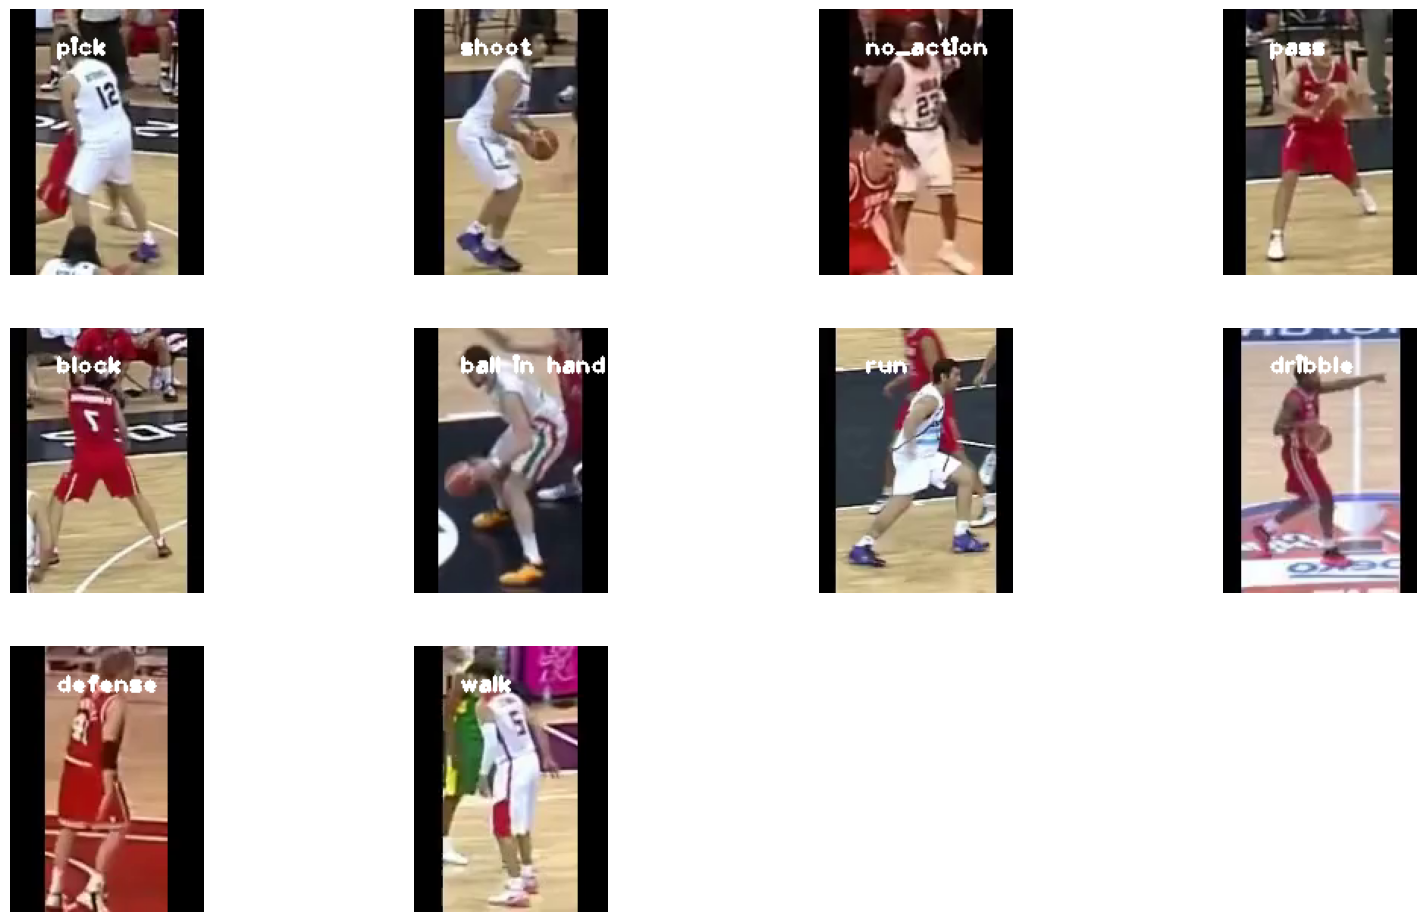

In [3]:
plt.figure(figsize=(20, 20))

#reading class names
with open('dataset/labels_dict.json', 'r') as f:
    js = json.load(f)

with open("dataset/annotation_dict.json", "r") as f:
    annotations = json.load(f)

all_classes_names = list(js.values())


random_range = random.sample(range(len(all_classes_names)-1),10)



#iterating through all generated random values
for counter, random_index in enumerate(random_range,1):
    #selcet class name
    selected_class_name = all_classes_names[random_index]
    
    video_file_names_list = []

    #list of all video files with class
    for el in annotations.keys():
        
        if annotations[el] == random_index:
            video_file_names_list.append(el + ".mp4")
    
   
    #random selection of video from the class
    selected_video_file = random.choice(video_file_names_list)
   

    #read video
    
    video = cv2.VideoCapture("dataset/examples/" + selected_video_file)
    
    #read firstr frame
    _, frame = video.read()

    #release video(only read onw frame)
    video.release()

    #convert to rgb
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    #write text on the video frame
    cv2.putText(rgb_frame, selected_class_name, (30, 30), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2)
    #display the frame
    plt.subplot(5,4,counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

PREPROCCESING THE DATA

In [4]:
#resize 
IMAGE_HEIGHT, IMAGE_WIDTH = 64,64

#number of frames fed into the model
SEQUENCE_LENGTH = 10

#dataset dir
DATASET_DIR = "dataset/examples"

#classes
CLASS_LIST =  all_classes_names


Function to extract, resize and normalize frames

In [7]:
def frame_extraction(video_path):

    #list to store video frames
    frames_list = []

    #read the video
    video = cv2.VideoCapture(video_path)

    #iterate trough video frames
    for frame_counter in range(SEQUENCE_LENGTH):


        #reading the frame 
        success,frame = video.read()

        #if the frame is not read correctly exit the loop
        if not success:
            break
            
    

        #resize the frame
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))

        

        #normalize the frame (good for neural networks)
        normalized_frame = resized_frame / 255.0

        

        #append the normalized frame
        frames_list.append(normalized_frame)
       

    #release the video
    video.release()

    
    return frames_list



dataset creation function

In [8]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    

    #iterate through all the classes
    for class_index, class_name in enumerate(CLASS_LIST):

        #display the name of the class whose data is being extracted
        print(f"Extracting Data of Class: {class_name}")

        #get the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(DATASET_DIR))

        #iterate through all the files present in the files list
        for file_name in files_list:
            
            #check if list has the key
            
            if file_name[:-4] in annotations.keys() and not(file_name[2] == "3"):
                #check if file has the class
                if annotations[file_name[:-4]] == class_index:

                    #get the complete video path
                    video_file_path = os.path.join(DATASET_DIR, file_name)

                    #get the frames from the video
                    frames = frame_extraction(video_file_path)
                    
                    
                    #igonre the files with less than 20 frames
                    if len(frames) == SEQUENCE_LENGTH:
                       
                        
                        #append the data to the correct list
                        features.append(frames)
                        labels.append(class_index)
                        video_files_paths.append(video_file_path)

  

    return features, labels, video_files_paths
    

    

Utilize the function create_dataset - getting features

In [ ]:
#create dataset
features, labels, video_files_paths = create_dataset()

Labels to one_hot_format

In [10]:
#using keras to_categorical
labels = tf.keras.utils.to_categorical(labels)

Split the dataset 

In [11]:
#split intoo train set(75%) and test set(25%)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

Implement convLSTM approach

In [13]:
 #construct the model 
def build_model():
   
    model = Sequential()

    model.add(ConvLSTM2D(filters= 4, kernel_size=(3,3), activation='tanh', data_format="channels_last",recurrent_dropout=0.2, return_sequences=True,input_shape=(SEQUENCE_LENGTH, IMAGE_WIDTH, IMAGE_HEIGHT, 3)))

    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format="channels_last"))

    model.add(TimeDistributed(Dropout(0.2)))


    model.add(ConvLSTM2D(filters= 8, kernel_size=(3,3), activation='tanh', data_format="channels_last",recurrent_dropout=0.2, return_sequences=True,input_shape=(SEQUENCE_LENGTH, IMAGE_WIDTH, IMAGE_HEIGHT, 3)))

    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format="channels_last"))

    model.add(TimeDistributed(Dropout(0.2)))


    model.add(ConvLSTM2D(filters= 14, kernel_size=(3,3), activation='tanh', data_format="channels_last",recurrent_dropout=0.2, return_sequences=True,input_shape=(SEQUENCE_LENGTH, IMAGE_WIDTH, IMAGE_HEIGHT, 3)))

    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format="channels_last"))

    model.add(TimeDistributed(Dropout(0.2)))


    model.add(ConvLSTM2D(filters= 16, kernel_size=(3,3), activation='tanh', data_format="channels_last",recurrent_dropout=0.2, return_sequences=True,input_shape=(SEQUENCE_LENGTH, IMAGE_WIDTH, IMAGE_HEIGHT, 3)))

    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format="channels_last"))

    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    #softmax gives you probabilities of each class
    model.add(Dense(len(CLASS_LIST), activation='softmax'))

    print(model.summary())

    return model


In [ ]:
model = build_model()

Compile the model and train

In [ ]:
#create instance of Early stopping callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

#Compile the model and specify loss function, optimizer and metrics values to the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("finished compiling")

#train the model
history = model.fit(train_features, train_labels, epochs = 50, batch_size = 2, validation_split=0.2, callbacks = [early_stopping_callback])
